# <center>ECE1724 - Midterm Report - Dataset</center>
### <center>Team 1 - Multi-criteria optimal routing</center>
**<center>Agasti Kishor Dukare | Student ID: 1005602019</center>**
**<center>Qingqing Zhou | Student ID: 1003782463</center>**
**<center>Yunyi Zhu  | Student ID: 1002079252</center>**

# Prepare environment: 

### Install packages and dependencies:

- osmnx dependency: Rtree `!apt-get install libspatialindex-c4v5`
- install ffmpeg to support animations (used with matplotlib): `apt-get install ffmpeg`

### Install python packages:
Run `pip install -r requirements.txt` for venv or `pip3 install -r requirements.txt`

Or manually install them one by one:
- install osmnx: `pip install osmnx` (if running on colab, after installing osmnx, need to restart runtime)
- install plot tools: `pip install ipyleaflet`
- install plotly: `pip install plotly`
- install folium: `pip install folium`

# Prepare Dataset

All the experiments use OSM data. Each experiment may use different query engine with or without pre-processing or post-processing.

In [153]:
import osmnx as ox
from ipyleaflet import *
import networkx as nx
import plotly.graph_objects as obj
import numpy as np

## 1. Use graph_from_bbox() from osmnx

Use the [tool](http://bboxfinder.com/#43.609296,-79.640236,43.691742,-79.340515) to get the coordinates of the bounding box, which includes Pearson Airport and University of Toronto

`[bbox:43.609296,-79.640236,43.691742,-79.340515];`

From osmnx, use [graph_from_bbox()](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.graph.graph_from_bbox) API to query the data within the bounding box following the following order
- northern latitude of bounding box
- southern latitude of bounding box
- eastern longitude of bounding box
- western longitude of bounding box

In [154]:
# setup osmnx to be able to save the data to an .osm file
utn = ox.settings.useful_tags_node
oxna = ox.settings.osm_xml_node_attrs
oxnt = ox.settings.osm_xml_node_tags
utw = ox.settings.useful_tags_way
oxwa = ox.settings.osm_xml_way_attrs
oxwt = ox.settings.osm_xml_way_tags
utn = list(set(utn + oxna + oxnt))
utw = list(set(utw + oxwa + oxwt))
ox.config(all_oneway=True, useful_tags_node=utn, useful_tags_way=utw)

In [155]:
#If you're in any VPN, it may block you from accessing the Overpass or OSM server. Disable VPN when running this command
G = ox.graph_from_bbox(43.691742, 43.609296, -79.340515, -79.640236, retain_all = True)

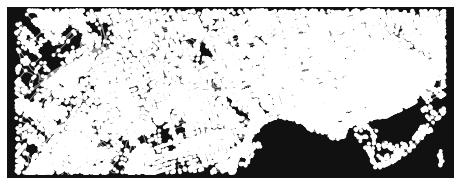

In [156]:
# plot the graph
fig, ax = ox.plot_graph(G)

In [157]:
# save to .osm file
# ox.save_graph_xml(G, filepath='./data/airport-toronto.osm')

__Findings:__

It could be time consuming running `graph_from_bbbox()` each time. Therefore, saving the result to an .osm file and use `graph_from_xml()` API to load the graph from existing file makes the process more efficient. However, this results a 32MB osm file and it is __not a flexible way__ to query only the data that we are interested.

## 2. Use BBBike

Select the region or bounding box to query the data from [BBBike](https://extract.bbbike.org/)

We save the query result from BBBike into file `downtown_data.osm` and retrieve them as below.

In [158]:
#Select OSM.Xml for downtown toronto
G = ox.graph_from_xml("data/downtown_data.osm", retain_all = True)

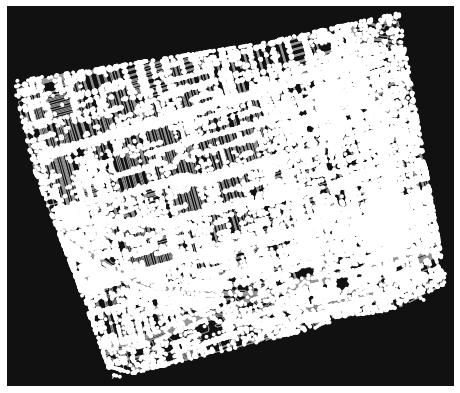

In [159]:
fig, ax = ox.plot_graph(G)

In [160]:
# extract the nodes and ways from the graph
nodes, ways =  ox.graph_to_gdfs(G)

In [161]:
# we may query the specific 
nodes_hw = nodes.dropna(subset=['highway'])
nodes_new = nodes_hw[nodes_hw.highway=="bus_stop"]
nodes_new

,y,x,osmid,highway,ref,geometry
238753589,43.663868,-79.398618,238753589,bus_stop,NaN,POINT (-79.39862 43.66387)
238753600,43.664235,-79.398227,238753600,bus_stop,07849,POINT (-79.39823 43.66424)
295319864,43.671739,-79.380379,295319864,bus_stop,NaN,POINT (-79.38038 43.67174)
295319867,43.671432,-79.380646,295319867,bus_stop,NaN,POINT (-79.38065 43.67143)
295319922,43.674484,-79.379938,295319922,bus_stop,NaN,POINT (-79.37994 43.67448)
...,...,...,...,...,...,...
7123722164,43.641957,-79.436147,7123722164,bus_stop,11723,POINT (-79.43615 43.64196)
7123722165,43.635108,-79.432904,7123722165,bus_stop,11635,POINT (-79.43290 43.63511)
7137874040,43.648972,-79.385741,7137874040,bus_stop,15838,POINT (-79.38574 43.64897)
7815551871,43.663097,-79.383896,7815551871,bus_stop,NaN,POINT (-79.38390 43.66310)


In [162]:
#See unique highway types
l = ways.highway.tolist()
kl = list()
for i in l:
    if(isinstance(i, str)):
        kl.append(i)
set(kl)

{'bus_stop',
 'construction',
 'corridor',
 'cycleway',
 'elevator',
 'footway',
 'living_street',
 'motorway',
 'motorway_link',
 'path',
 'pedestrian',
 'platform',
 'residential',
 'secondary',
 'secondary_link',
 'service',
 'steps',
 'tertiary',
 'tertiary_link',
 'track',
 'unclassified'}

In [163]:
#Select instances with cycleway
ways_hw = ways.dropna(subset=['highway'])
hw_new = ways_hw[ways_hw.highway=="cycleway"]
hw_new

,osmid,highway,lanes,bridge,name,ref,maxspeed,oneway,length,geometry,access,landuse,service,width,junction,tunnel,area,u,v,key
307,697464863,cycleway,NaN,NaN,NaN,NaN,NaN,NaN,11.415,"LINESTRING (-79.41147 43.64569, -79.41159 43.6...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,23922843,527025680,0
2564,7969156,cycleway,NaN,NaN,NaN,NaN,NaN,NaN,52.429,"LINESTRING (-79.39350 43.64447, -79.39354 43.6...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,59566216,3066077408,0
2565,414868318,cycleway,NaN,NaN,NaN,NaN,NaN,NaN,28.711,"LINESTRING (-79.39350 43.64447, -79.39323 43.6...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,59566216,3052755780,0
3015,836133756,cycleway,NaN,NaN,Shaw Street,NaN,30,NaN,30.676,"LINESTRING (-79.42524 43.66732, -79.42514 43.6...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,60797496,60797493,0
3149,3979618,cycleway,NaN,NaN,Martin Goodman Trail,NaN,20,NaN,6.676,"LINESTRING (-79.39207 43.63754, -79.39199 43.6...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,60948110,6274973879,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61744,833270390,cycleway,NaN,NaN,NaN,NaN,NaN,NaN,15.258,"LINESTRING (-79.38047 43.64097, -79.38064 43.6...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7778706794,7778706796,0
61747,833270390,cycleway,NaN,NaN,NaN,NaN,NaN,NaN,11.564,"LINESTRING (-79.38064 43.64091, -79.38078 43.6...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7778706796,7778706795,0
61749,833270390,cycleway,NaN,NaN,NaN,NaN,NaN,NaN,89.392,"LINESTRING (-79.37945 43.64130, -79.38047 43.6...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7778706797,7778706794,0
61750,833270390,cycleway,NaN,NaN,NaN,NaN,NaN,NaN,76.095,"LINESTRING (-79.37861 43.64160, -79.37945 43.6...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7778706798,7778706797,0


__Findings:__

One of the advantage of BBBike is that it provides ability to extract data from Planet.osm in various formats including OSM, PBF, o5m, Garmin, Navit, Osmand, mapsforge CSV, SVG, maps.me, libosmium OPL, GeoJSON, SQLite, text, or Esri shapefile. This makes it useful when we need data in specific format. However, BBBike does not provide ability to query data with filters such as highway type. Thus we need to extract whole data and then filter out downloaded data manually. 

## 3. Use Overpass

Use __Overpass__ to query data from OSM via [Overpass Turbo](https://overpass-turbo.eu/#)

* Step 1: query the data via `Overpass Turbo`
* Step 2: save the result to a _.osm_ file
* Step 3: use osmnx `graph_from_xml` to load the graph from _.osm_
* Step 4: analyze and process the data

### Dataset 1: Only contain specific `highway` values

```
  way["highway"="motorway"]({{bbox}});
  way["highway"="trunk"]({{bbox}});
  way["highway"="primary"]({{bbox}});
  way["highway"="secondary"]({{bbox}});
  way["highway"="tertiary"]({{bbox}});
  way["highway"="residential"]({{bbox}});
  way["highway"="motorway_link"]({{bbox}});
  way["highway"="trunk_link"]({{bbox}});
  way["highway"="primary_link"]({{bbox}});
  way["highway"="secondary_link"]({{bbox}});
  way["highway"="tertiary_link"]({{bbox}});
  way["highway"="living_street"]({{bbox}});
  way["highway"="service"]({{bbox}});
  way["highway"="track"]({{bbox}});
```  
Refer to _toronto_driving_way.oql_ for the query.

In [164]:
# load the osm data from overpass turbo into osmnx
G = ox.graph_from_xml("./data/toronto_driving_way.osm", retain_all = True)

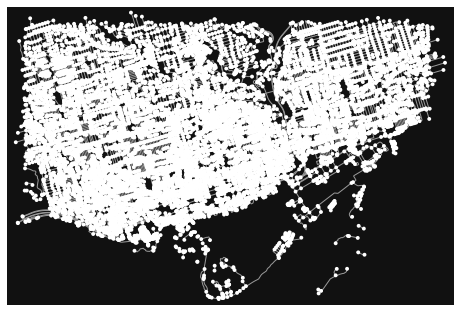

In [165]:
# plot the graph
fig, ax = ox.plot_graph(G)

__Findings:__

This dataset contains data that we interested and flexible to adjust to different area and include different attributes.

### Dataset 2: University of Toronto area with only specific `highway` values

We refined our dataset precisely to what we need by
- reduce the bounding box (interested area)
- include some factors to be considered as multi-criteria

**Considering following _criteria_ besides distance (length of the road):**
- bus stop: the more the bus stops on a roadside, the more complicated the road condition can become
- cycleways: affect the driving condition
- roadside parking: affect the driving condition
- restaurant: the more the restaurants on a roadside, the more complicated the road condition can become
- traffic signals and turn type: affect the route

check the [query](https://overpass-turbo.eu/s/ZcU)

```
/*
This query looks for all the ways that describe the area within the given bounding box as well as some travel speed factors, such as bus stops, restaurants and roadside parking.
*/

// university of toronto area
[bbox:43.653151,-79.404852,43.669384,-79.382536][out:xml];
// gather results
(
  // 1. query all the bus_stops
  nwr["highway"="bus_stop"];
  // 2. query all the restaurant
  nwr["amenity"="restaurant"];
);
out center;

(
  // 3. query all the roads
  way["highway"~"(motorway|trunk|primary|secondary|tertiary|residential|_link|living_street|service|track)"];
  
  // 4. query all possible roadside parking
  nwr["parking:lane:both"~"(parallel|diagonal|perpendicular|marked)"];
  nwr["parking:lane:left"~"(parallel|diagonal|perpendicular|marked)"];
  nwr["parking:lane:right"~"(parallel|diagonal|perpendicular|marked)"];
);
(._;>;);
// print results
out;
```

In [166]:
# load the osm data from overpass turbo into osmnx
# G = ox.graph_from_xml("./data/uoft-highway-factors.osm", retain_all = True)

__Findings:__

After reducing the area, with option `retain_all = True`, we get following errors:
```
KeyError: 'Edge(s) missing nodes 5194461974, 6642359884, 1410856574, 5194461975, 1410856604, 6642393788, 1410856605, 1410856602, 5194461977, 1410856571, 5194461973, 5194461978, 5194461976, 1410856572, 803247170, 5194425585, 6642393785, 6642393786, 6642393787, 1410856560 possibly due to clipping issue'
```

__Solution:__

Add missing nodes above to the query to get a complete graph. [fixed query](https://overpass-turbo.eu/s/ZeD)

```
/*
This query looks for all the ways that describe the area within the given bounding box as well as some travel speed factors, such as bus stops, restaurants and roadside parking.
*/

// university of toronto area
[bbox:43.653151,-79.404852,43.669384,-79.382536][out:xml];
// gather results
(
  // 1. query all the bus_stops
  nwr["highway"="bus_stop"];
  // 2. query all the restaurant
  nwr["amenity"="restaurant"];
);
out center;

(
  // 3. query all the roads
  way["highway"~"(motorway|trunk|primary|secondary|tertiary|residential|_link|living_street|service|track|cycleway)"];
  
  // 4. query all possible roadside parking
  nwr["parking:lane:both"~"(parallel|diagonal|perpendicular|marked)"];
  nwr["parking:lane:left"~"(parallel|diagonal|perpendicular|marked)"];
  nwr["parking:lane:right"~"(parallel|diagonal|perpendicular|marked)"];

 // 5. collect necessary remaining nodes to make sure retain_all work
  node(id:5194461974,6642359884,1410856574,5194461975,1410856604,6642393788,1410856605,1410856602,5194461977,1410856571,5194461973,5194461978,5194461976,1410856572,803247170,5194425585,6642393785,6642393786,6642393787,1410856560);
);

(._;>;);

// print results
out;
```

In [167]:
# load the osm data from overpass turbo into osmnx
G1 = ox.graph_from_xml("./data/uoft-highway-factors-fixed.osm", retain_all = True)

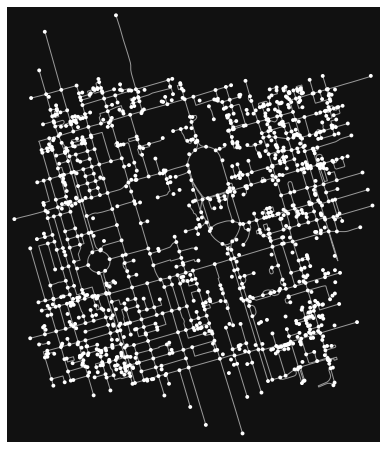

In [168]:
# plot the graph
fig, ax = ox.plot_graph(G1)

In [169]:
ox.plot_graph_folium(G1)

#### Graph/Map information and stats

In [170]:
import networkx as nx

# show number of networkx in the graph
nx.number_strongly_connected_components(G1)

931

In [171]:
# show basic stats
ox.basic_stats(G1)

{'n': 1287,
 'm': 1242,
 'k_avg': 1.93006993006993,
 'intersection_count': 689,
 'streets_per_node_avg': 1.912975912975913,
 'streets_per_node_counts': {0: 283,
  1: 315,
  2: 39,
  3: 536,
  4: 110,
  5: 3,
  6: 1},
 'streets_per_node_proportion': {0: 0.2198912198912199,
  1: 0.24475524475524477,
  2: 0.030303030303030304,
  3: 0.41647241647241645,
  4: 0.08547008547008547,
  5: 0.002331002331002331,
  6: 0.000777000777000777},
 'edge_length_total': 75570.61300000014,
 'edge_length_avg': 60.84590418679561,
 'street_length_total': 75570.61300000011,
 'street_length_avg': 60.845904186795586,
 'street_segments_count': 1242,
 'node_density_km': None,
 'intersection_density_km': None,
 'edge_density_km': None,
 'street_density_km': None,
 'circuity_avg': 1.0733220897261366,
 'self_loop_proportion': 0.004830917874396135,
 'clean_intersection_count': None,
 'clean_intersection_density_km': None}

In [172]:
# show extended stats
stats_ext = ox.extended_stats(G1,connectivity = True, ecc = True, bc=True, cc=True)

In [173]:
# show the center and diameter fields of the map
print("center =", stats_ext['center'], "diameter =", stats_ext['diameter'])

center = [29658390] diameter = 4666.124999999999


#### Extract nodes and ways

In [174]:
# Getting geopandas data frames to have a data structure representing the nodes and the ways in the graph
nodes, ways =  ox.graph_to_gdfs(G1)

In [175]:
nodes.head()

,y,x,osmid,highway,ref,geometry
238753589,43.663868,-79.398618,238753589,bus_stop,NaN,POINT (-79.39862 43.66387)
238753600,43.664235,-79.398227,238753600,bus_stop,07849,POINT (-79.39823 43.66424)
249989758,43.655889,-79.393378,249989758,NaN,NaN,POINT (-79.39338 43.65589)
265008563,43.668648,-79.395125,265008563,NaN,NaN,POINT (-79.39512 43.66865)
267314310,43.656166,-79.383636,267314310,NaN,NaN,POINT (-79.38364 43.65617)


In [176]:
nodes.loc[249989758]

y                                  43.6559
x                                 -79.3934
osmid                            249989758
highway                                NaN
ref                                    NaN
geometry    POINT (-79.3933785 43.6558894)
Name: 249989758, dtype: object

In [177]:
ways.head()

,osmid,highway,lanes,name,maxspeed,length,geometry,oneway,access,service,tunnel,width,bridge,u,v,key
0,"[3998177, 521697613]",secondary,"[2, 3]",Bloor Street West,50,126.418,"LINESTRING (-79.39982 43.66751, -79.39971 43.6...",NaN,NaN,NaN,NaN,NaN,NaN,20964579,24959526,0
1,4212261,tertiary,2,St George Street,30,32.336,"LINESTRING (-79.39982 43.66751, -79.39978 43.6...",NaN,NaN,NaN,NaN,NaN,NaN,20964579,416737810,0
2,5090496,residential,2,St George Street,40,60.701,"LINESTRING (-79.39982 43.66751, -79.39986 43.6...",NaN,NaN,NaN,NaN,NaN,NaN,20964579,1596859403,0
3,"[25757997, 216566669]",secondary,"[4, 5]",Bay Street,40,99.450,"LINESTRING (-79.38947 43.66972, -79.38942 43.6...",NaN,NaN,NaN,NaN,NaN,NaN,20964581,2144593271,0
4,4000039,secondary_link,1,NaN,NaN,71.443,"LINESTRING (-79.39249 43.66607, -79.39275 43.6...",yes,NaN,NaN,NaN,NaN,NaN,20979740,20979743,0


#### Extract useful information
**1) traffic signals**

In [178]:
# display all the nodes with traffic lights
nodes_hw = nodes.dropna(subset=['highway'])
nodes_traffic_signals = nodes_hw[nodes_hw.highway=="traffic_signals"]
nodes_traffic_signals

,y,x,osmid,highway,ref,geometry
20964579,43.667511,-79.399817,20964579,traffic_signals,NaN,POINT (-79.39982 43.66751)
20964581,43.669724,-79.389469,20964581,traffic_signals,NaN,POINT (-79.38947 43.66972)
20979760,43.657527,-79.389624,20979760,traffic_signals,NaN,POINT (-79.38962 43.65753)
20979761,43.657583,-79.389346,20979761,traffic_signals,NaN,POINT (-79.38935 43.65758)
20979763,43.668702,-79.394130,20979763,traffic_signals,NaN,POINT (-79.39413 43.66870)
...,...,...,...,...,...,...
339273928,43.661599,-79.380664,339273928,traffic_signals,NaN,POINT (-79.38066 43.66160)
1551002988,43.652981,-79.382635,1551002988,traffic_signals,NaN,POINT (-79.38264 43.65298)
3179025278,43.663608,-79.390830,3179025278,traffic_signals,NaN,POINT (-79.39083 43.66361)
3789187401,43.665044,-79.393908,3789187401,traffic_signals,NaN,POINT (-79.39391 43.66504)


**2) bus stops**

In [179]:
# display all the nodes with bus stop
nodes_bus_stop = nodes_hw[nodes_hw.highway=="bus_stop"]
nodes_bus_stop

,y,x,osmid,highway,ref,geometry
238753589,43.663868,-79.398618,238753589,bus_stop,NaN,POINT (-79.39862 43.66387)
238753600,43.664235,-79.398227,238753600,bus_stop,07849,POINT (-79.39823 43.66424)
304881799,43.664747,-79.395594,304881799,bus_stop,07850,POINT (-79.39559 43.66475)
304881868,43.664591,-79.395809,304881868,bus_stop,NaN,POINT (-79.39581 43.66459)
304896162,43.663559,-79.390299,304896162,bus_stop,NaN,POINT (-79.39030 43.66356)
...,...,...,...,...,...,...
6721977921,43.657176,-79.384189,6721977921,bus_stop,NaN,POINT (-79.38419 43.65718)
6721977922,43.654211,-79.383005,6721977922,bus_stop,NaN,POINT (-79.38300 43.65421)
6856254747,43.664758,-79.395738,6856254747,bus_stop,NaN,POINT (-79.39574 43.66476)
7815551871,43.663097,-79.383896,7815551871,bus_stop,NaN,POINT (-79.38390 43.66310)


**3) cycleways**

In [180]:
# show instances with cycleway
ways_hw = ways.dropna(subset=['highway'])
ways_cycleway = ways_hw[ways_hw.highway=="cycleway"]
ways_cycleway

,osmid,highway,lanes,name,maxspeed,length,geometry,oneway,access,service,tunnel,width,bridge,u,v,key
1037,696677975,cycleway,NaN,Wellesley-Hoskin Cycle Track,NaN,5.475,"LINESTRING (-79.39083 43.66361, -79.39080 43.6...",yes,NaN,NaN,NaN,NaN,NaN,3179025278,3789187399,0
1059,696677976,cycleway,NaN,Wellesley-Hoskin Cycle Track,NaN,16.846,"LINESTRING (-79.39062 43.66361, -79.39074 43.6...",yes,NaN,NaN,NaN,NaN,NaN,3340615393,3179025278,0
1081,696677975,cycleway,NaN,Wellesley-Hoskin Cycle Track,NaN,18.166,"LINESTRING (-79.39080 43.66356, -79.39079 43.6...",yes,NaN,NaN,NaN,NaN,NaN,3789187399,3340615393,1
1083,312084546,cycleway,NaN,Wellesley-Hoskin Cycle Track,NaN,383.737,"LINESTRING (-79.39391 43.66504, -79.39383 43.6...",no,NaN,NaN,NaN,2,NaN,3789187401,3179025278,0


**4) Roadside parking** (???)

In [184]:
# Convert bounding box coordinates to shapely Polygon
G_poly = ox.utils_geo.bbox_to_poly(43.669384,43.653151,-79.382536,-79.404852)

In [194]:
selected_parking = ['parallel', 'diagonal', 'perpendicular', 'marked']
G_parking = ox.geometries_from_polygon(G_poly,  tags = {'parking:lane:left':selected_parking, 'parking:lane:right':selected_parking, 'parking:lane:both':selected_parking} )
G_parking.head()

/mnt/w/Projects/ece1724/env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,unique_id,osmid,element_type,highway,geometry,nodes,cycleway,lanes,lit,maxspeed,name,name:zh,parking:condition:right:1,parking:condition:right:1:residents,parking:condition:right:1:time_interval,parking:condition:right:2,parking:condition:right:2:time_interval,parking:lane:right,sidewalk,surface
0,way/10070564,10070564,way,tertiary,"LINESTRING (-79.39380 43.65375, -79.39339 43.6...","[393552061, 29604989, 1141669502, 6488691281, ...",lane,2,yes,30,Beverley Street,比華利街,residents,6D,00:01-07:00,ticket,Mo-Sa 08:00-21:00; Su 13:00-21:00,parallel,both,asphalt
1,way/446793023,446793023,way,tertiary,"LINESTRING (-79.39383 43.65382, -79.39383 43.6...","[29604747, 6375005415, 393552061]",lane,2,yes,30,Beverley Street,比華利街,residents,6D,00:01-07:00,ticket,Mo-Sa 08:00-21:00; Su 13:00-21:00,parallel,both,asphalt


**5) Amenity Density**

In [192]:
selected_amenities = ['restaurant', 'bar', 'cafe']
G_amenities = ox.geometries_from_polygon(G_poly,  tags = {'amenity':selected_amenities} )
G_amenities.head()

/mnt/w/Projects/ece1724/env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,unique_id,osmid,element_type,addr:city,addr:housenumber,addr:postcode,addr:street,amenity,brand,brand:wikidata,...,payment:debit_cards,short_name,brand:en,brand:zh,addr:country,toilets:access,shop,nodes,building,start_date:restaurant
0,node/60930953,60930953,node,Toronto,246,M5S 1V4,Bloor Street West,cafe,Tim Hortons,Q175106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node/80927400,80927400,node,NaN,NaN,NaN,NaN,cafe,Second Cup,Q862180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node/95378352,95378352,node,NaN,NaN,NaN,NaN,cafe,Tim Hortons,Q175106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node/118421701,118421701,node,NaN,NaN,NaN,NaN,cafe,Starbucks,Q37158,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node/176544089,176544089,node,NaN,NaN,NaN,NaN,cafe,Tim Hortons,Q175106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/mnt/w/Projects/ece1724/env/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

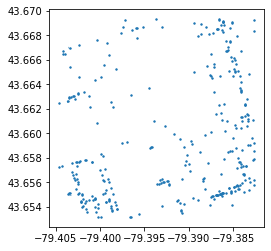

In [193]:
G_amenities.plot(markersize=2)

#### Display nodes and their edge

In [181]:
# pick a way (edge)
ways.loc[200]

osmid                                                 4652023
highway                                           residential
lanes                                                       1
name                                              Ross Street
maxspeed                                                  NaN
length                                                 49.398
geometry    LINESTRING (-79.396283 43.6567346, -79.3962992...
oneway                                                    yes
access                                                    NaN
service                                                   NaN
tunnel                                                    NaN
width                                                     NaN
bridge                                                    NaN
u                                                    29604724
v                                                   207713597
key                                                         0
Name: 20

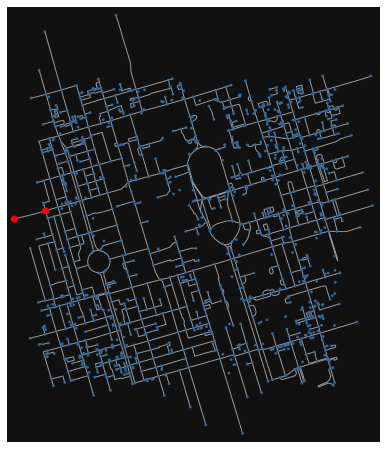

In [182]:
# highlight the beginning and end nodes of this way
highlighted = [26007927, 26007926]
nc = ['r' if node in highlighted else '#336699' for node in G1.nodes()]
ns = [50 if node in highlighted else 8 for node in G1.nodes()]
fig, ax = ox.plot_graph(G1, node_size=ns, node_color=nc, node_zorder=2)